# Regressoes Polinomiais com PCA

In [50]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

In [51]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import csv
import datetime
import seaborn as sns
import numpy as np
import datetime as dt
from matplotlib.ticker import PercentFormatter
import math

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [54]:
cenarios_expansao = pd.read_csv("cenarios_expansao.csv")
faturamento_lojas_atuais = pd.read_csv("faturamento_lojas_atuais.csv")
lojas_atuais = pd.read_csv("lojas_atuais.csv")

In [55]:
data_diego = pd.read_csv("faturamento_consolidade_com_feriado_e_receita_da_categoria.csv")

In [56]:
data_diego.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,ano,mes,categoria_loja,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,1,40,0.0,0.00,0.0,0.000000,0.00,1.0,552910.464333
1,1,2017-01-01,404108.77,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2017,1,40,611797.3,876921.63,1257613.0,915443.976667,441833.37,1.0,552910.464333
2,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,2,40,0.0,0.00,0.0,0.000000,0.00,0.0,435209.493667
3,1,2017-02-01,483610.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2017,2,40,611797.3,876921.63,1257613.0,915443.976667,395340.22,0.0,435209.493667
4,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,3,40,0.0,0.00,0.0,0.000000,0.00,0.0,520654.621333


In [57]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [58]:
def get_polynomial_features_model(X_train, X_test, Y_train, Y_test, degree=1, just_show_performance=True):
    """Creates a polynomial regression model for the given degree, with degree 1 as standard;
        Optionally, can show the model performance by printing RMSE, R2 and the adjusted R2 or return
        the adjusted R2 of the model as output."""
    
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    
    model = LinearRegression(normalize=True)   
    model.fit(X_train_poly, Y_train)
    
    #predicting on training data
    y_test_predict = model.predict(poly_features.fit_transform(X_test))
    
    # evaluating the model on test dataset
    #rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = math.sqrt(mse)
    
    r2_test = r2_score(Y_test, y_test_predict)
    adjusted_r_squared = 1 - (1-r2_test)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
   
    if just_show_performance:
        print("The model performance:\n")
        print("RMSE of test set is {}".format(rmse))
        print("R2 score of test set is {}".format(r2_test))
        print("adjusted-R2 score of test set is {}".format(adjusted_r_squared))
           
        
    else:
        return rmse

In [59]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [60]:
def get_PCA(n_comp, data):
    """auxiliar function to get the PCA transformation for the given dataset for the given 
        number of components"""
    
    variables = ['cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'categoria_loja',
       'receita_trim1', 'receita_trim2', 'receita_trim3', 'receita_media',
       'receita_ano_passado', 'cnt_feriados', 'receita_minha_categoria', 'MES',
       'loja']
    
    
    x = data.loc[:, variables].values
    y = data.loc[:,['receita']].values    
    X = StandardScaler().fit_transform(x)
    X = pd.DataFrame(x)
        
    pca = PCA(n_components = n_comp)
    x_pca = pca.fit_transform(X)
    x_pca = pd.DataFrame(x_pca)
    x_pca['receita']=y
    #x_pca.head('
    
    return x_pca

In [61]:
def get_rmse_matrix(data):
    """Build the adjusted-R²-matrix for different combinations of degrees and 
       quantity of PCs for the given dataset"""
    
    degrees = (1, 2, 3, 4) #degrees for the different polynomial regressions
    n_components = (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17) #maximum of 8 PCs since it is enough to hold all original variance
    n_components_rmse = {2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: []}

    for i in n_components:
        x_pca = get_PCA(i, data)
        Y = x_pca['receita']
        X = x_pca.loc[:, x_pca.columns != 'receita']
        train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=0, test_size=0.3)
        for j in degrees:
            rmse = get_polynomial_features_model(train_X, val_X, train_y, val_y, j, just_show_performance=False)
            n_components_rmse[i].append(round_up(rmse, 2))

    rmse_matrix = pd.DataFrame(data=n_components_rmse)
    rmse_matrix = rmse_matrix.rename(index={0: "degree 1", 1: "degree 2", 2: "degree 3", 3: "degree 4", 4: "degree 5", 5: "degree 6"})
    rmse_matrix = rmse_matrix.rename(columns={2: "2 PCs", 3: "3 PCs", 4: "4 PCs", 5: "5 PCs", 6: "6 PCs", 7: "7Pcs", 8: "8 PCs", 9: "9 PCs", 10: "10", 11: "11", 12: "12", 13: "13", 14: "14", 15: "15", 16: "16", 17: "17PCs"})
    
    return rmse_matrix

In [62]:
def mostra_receita(df, eixo_x, label):
    eixo_y = df['receita']
    #eixo_x = np.arrange(0, 12, 1)

    fig, ax = plt.subplots()
    ax.plot(eixo_x, eixo_y)
    ax.set(xlabel=label, ylabel="Receita ($)", title="Variaçaão da receita")
    ax.grid()
    nome = "EDA_graf_receita_features" + label + ".png"
    fig.savefig(nome)
    plt.show()

In [63]:
lojas_atuais_com_faturamento = pd.merge(lojas_atuais, faturamento_lojas_atuais,left_on='cod_loja',right_on='cod_loja', how='outer')
lojas_atuais_com_faturamento.shape

(1003094, 26)

In [64]:
#df = lojas_atuais_com_faturamento
df = data_diego
df.head()

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,ano,mes,categoria_loja,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,1,40,0.0,0.00,0.0,0.000000,0.00,1.0,552910.464333
1,1,2017-01-01,404108.77,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2017,1,40,611797.3,876921.63,1257613.0,915443.976667,441833.37,1.0,552910.464333
2,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,2,40,0.0,0.00,0.0,0.000000,0.00,0.0,435209.493667
3,1,2017-02-01,483610.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2017,2,40,611797.3,876921.63,1257613.0,915443.976667,395340.22,0.0,435209.493667
4,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,2016,3,40,0.0,0.00,0.0,0.000000,0.00,0.0,520654.621333


In [65]:
df['MES'] = ""
mes = []
for i in range(df.shape[0]):
    if (df['ano'][i] == 2016):
        mes.append(df['mes'][i])
    else:
        mes.append(df['mes'][i] + 12)
df['MES'] = mes

In [66]:
datas = pd.DataFrame({'year': df['ano'],
                      'month': df['mes'],
                       'day': [1 for i in range(df.shape[0])]})
datetime = pd.to_datetime(datas)

In [67]:
df['data_stamp'] = datetime

In [68]:
df.head(15)

,cod_loja,datetime,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,...,categoria_loja,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria,MES,data_stamp
0,1,2016-01-01,441833.37,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,0.00,0.00,0.00,0.000000,0.00,1.0,552910.464333,1,2016-01-01
1,1,2017-01-01,404108.77,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,611797.30,876921.63,1257613.00,915443.976667,441833.37,1.0,552910.464333,13,2017-01-01
2,1,2016-02-01,395340.22,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,0.00,0.00,0.00,0.000000,0.00,0.0,435209.493667,2,2016-02-01
3,1,2017-02-01,483610.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,611797.30,876921.63,1257613.00,915443.976667,395340.22,0.0,435209.493667,14,2017-02-01
4,1,2016-03-01,587810.18,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,0.00,0.00,0.00,0.000000,0.00,0.0,520654.621333,3,2016-03-01
5,1,2017-03-01,626291.59,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,611797.30,876921.63,1257613.00,915443.976667,587810.18,0.0,520654.621333,15,2017-03-01
6,1,2016-04-01,534618.84,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,441833.37,395340.22,587810.18,474994.590000,0.00,1.0,540559.447000,4,2016-04-01
7,1,2017-04-01,612062.60,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,404108.77,483610.18,626291.59,504670.180000,534618.84,1.0,540559.447000,16,2017-04-01
8,1,2016-05-01,595477.92,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,441833.37,395340.22,587810.18,474994.590000,0.00,1.0,762363.788000,5,2016-05-01
9,1,2017-05-01,748281.98,4125506005002,4125506,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,1,21.76,FEATURE_05_VALUE_04,...,40,404108.77,483610.18,626291.59,504670.180000,595477.92,1.0,762363.788000,17,2017-05-01


In [69]:
receita_loja_mes = df.groupby(['cod_loja', 'data_stamp']).sum()

In [70]:
receita_loja_mes.head(50)

receita         cod_ap  cod_municipio  feature_03  \
cod_loja data_stamp                                                         
1        2016-01-01   441833.37  4125506005002        4125506           1   
         2016-02-01   395340.22  4125506005002        4125506           1   
         2016-03-01   587810.18  4125506005002        4125506           1   
         2016-04-01   534618.84  4125506005002        4125506           1   
         2016-05-01   595477.92  4125506005002        4125506           1   
         2016-06-01   589947.05  4125506005002        4125506           1   
         2016-07-01   563814.03  4125506005002        4125506           1   
         2016-08-01   625181.36  4125506005002        4125506           1   
         2016-09-01   583509.12  4125506005002        4125506           1   
         2016-10-01   611797.30  4125506005002        4125506           1   
         2016-11-01   876921.63  4125506005002        4125506           1   
         2016-12-01  1257613.00  4125506005002        4125506           1   
         2017-01-01   404108.77  4125506005002        4125506           1   
         2017-02-01   483610.18  4125506005002        4125506           1   
         2017-03-01   626291.59  4125506005002        4125506           1   
         2017-04-01   612062.60  4125506005002        4125506           1   
         2017-05-01   748281.98  4125506005002        4125506           1   
         2017-06-01   700312.65  4125506005002        4125506           1   
         2017-07-01   646369.23  4125506005002        4125506           1   
         2017-08-01   757850.68  4125506005002        4125506           1   
         2017-09-01   602313.53  4125506005002        4125506           1   
         2017-10-01   637339.76  4125506005002        4125506           1   
         2017-11-01   891173.22  4125506005002        4125506           1   
         2017-12-01  1216996.84  4125506005002        4125506           1   
2        2016-01-01    54660.39  5300108005004        5300108           1   
         2016-02-01    49120.72  5300108005004        5300108           1   
         2016-03-01    53421.91  5300108005004        5300108           1   
         2016-04-01    60167.41  5300108005004        5300108           1   
         2016-05-01    89412.94  5300108005004        5300108           1   
         2016-06-01    68925.00  5300108005004        5300108           1   
         2016-07-01    69741.67  5300108005004        5300108           1   
         2016-08-01    65833.00  5300108005004        5300108           1   
         2016-09-01    56715.82  5300108005004        5300108           1   
         2016-10-01    53209.15  5300108005004        5300108           1   
         2016-11-01    53830.14  5300108005004        5300108           1   
         2016-12-01   108589.21  5300108005004        5300108           1   
         2017-01-01    55235.99  5300108005004        5300108           1   
         2017-02-01    39019.13  5300108005004        5300108           1   
         2017-03-01    62446.56  5300108005004        5300108           1   
         2017-04-01    52944.17  5300108005004        5300108           1   
         2017-05-01    86638.16  5300108005004        5300108           1   
         2017-06-01    76081.09  5300108005004        5300108           1   
         2017-07-01    60697.95  5300108005004        5300108           1   
         2017-08-01    72463.56  5300108005004        5300108           1   
         2017-09-01    64936.11  5300108005004        5300108           1   
         2017-10-01    59996.08  5300108005004        5300108           1   
         2017-11-01    76670.53  5300108005004        5300108           1   
         2017-12-01    92232.32  5300108005004        5300108           1   
3        2016-01-01   161428.96  3550308005052        3550308           1   
         2016-02-01   132417.93  3550308005052        3550308           1   

                   

In [71]:
df = receita_loja_mes

In [72]:
data = []
for index in df.index:
    #print(index[1])
    data.append(index[1])

In [73]:
df['data'] = data

In [74]:
loja = [index[0] for index in df.index]
df['loja'] = loja

In [75]:
df.head()

receita         cod_ap  cod_municipio  feature_03  \
cod_loja data_stamp                                                        
1        2016-01-01  441833.37  4125506005002        4125506           1   
         2016-02-01  395340.22  4125506005002        4125506           1   
         2016-03-01  587810.18  4125506005002        4125506           1   
         2016-04-01  534618.84  4125506005002        4125506           1   
         2016-05-01  595477.92  4125506005002        4125506           1   

                     feature_04  feature_06  feature_07  feature_08  \
cod_loja data_stamp                                                   
1        2016-01-01       21.76          31    0.168922    0.167659   
         2016-02-01       21.76          31    0.168922    0.167659   
         2016-03-01       21.76          31    0.168922    0.167659   
         2016-04-01       21.76          31    0.168922    0.167659   
         2016-05-01       21.76          31    0.168922    0.167659   

                     feature_09  feature_10  ...  receita_trim1  \
cod_loja data_stamp                          ...                  
1        2016-01-01  115.958848    2.349821  ...           0.00   
         2016-02-01  115.958848    2.349821  ...           0.00   
         2016-03-01  115.958848    2.349821  ...           0.00   
         2016-04-01  115.958848    2.349821  ...      441833.37   
         2016-05-01  115.958848    2.349821  ...      441833.37   

                     receita_trim2  receita_trim3  receita_media  \
cod_loja data_stamp                                                
1        2016-01-01           0.00           0.00           0.00   
         2016-02-01           0.00           0.00           0.00   
         2016-03-01           0.00           0.00           0.00   
         2016-04-01      395340.22      587810.18      474994.59   
         2016-05-01      395340.22      587810.18      474994.59   

                     receita_ano_passado  cnt_feriados  \
cod_loja data_stamp                                      
1        2016-01-01                  0.0           1.0   
         2016-02-01                  0.0           0.0   
         2016-03-01                  0.0           0.0   
         2016-04-01                  0.0           1.0   
         2016-05-01                  0.0           1.0   

                     receita_minha_categoria  MES       data  loja  
cod_loja data_stamp                                                 
1        2016-01-01            552910.464333    1 2016-01-01     1  
         2016-02-01            435209.493667    2 2016-02-01     1  
         2016-03-01            520654.621333    3 2016-03-01     1  
         2016-04-01            540559.447000    4 2016-04-01     1  
         2016-05-01            762363.788000    5 2016-05-01     1  

[5 rows x 30 columns]

In [76]:
indices = [i for i in range(df.shape[0])]
df['indice'] = indices
df = df.set_index('indice')

In [77]:
df.head()

,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria,MES,data,loja
indice,,,,,,,,,,,,,,,,,,,,,
0,441833.37,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0.00,0.00,0.00,0.00,0.0,1.0,552910.464333,1,2016-01-01,1
1,395340.22,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0.00,0.00,0.00,0.00,0.0,0.0,435209.493667,2,2016-02-01,1
2,587810.18,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0.00,0.00,0.00,0.00,0.0,0.0,520654.621333,3,2016-03-01,1
3,534618.84,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,441833.37,395340.22,587810.18,474994.59,0.0,1.0,540559.447000,4,2016-04-01,1
4,595477.92,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,441833.37,395340.22,587810.18,474994.59,0.0,1.0,762363.788000,5,2016-05-01,1


In [78]:
df_loja1 = df[df['loja'] == 1]
df_loja1.head()

,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria,MES,data,loja
indice,,,,,,,,,,,,,,,,,,,,,
0,441833.37,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0.00,0.00,0.00,0.00,0.0,1.0,552910.464333,1,2016-01-01,1
1,395340.22,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0.00,0.00,0.00,0.00,0.0,0.0,435209.493667,2,2016-02-01,1
2,587810.18,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,0.00,0.00,0.00,0.00,0.0,0.0,520654.621333,3,2016-03-01,1
3,534618.84,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,441833.37,395340.22,587810.18,474994.59,0.0,1.0,540559.447000,4,2016-04-01,1
4,595477.92,4125506005002,4125506,1,21.76,31,0.168922,0.167659,115.958848,2.349821,...,441833.37,395340.22,587810.18,474994.59,0.0,1.0,762363.788000,5,2016-05-01,1


In [79]:
df_master = df_loja1
df_master = df_master.resample('3M', on='data').mean()
indices = [i for i in range(df_master.shape[0])]
df_master['indice'] = indices
df_master = df_master.set_index('indice')
df_master.head(10)

,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,categoria_loja,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria,MES,loja
indice,,,,,,,,,,,,,,,,,,,,,
0,4.418334e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,5.529105e+05,1.0,1.0
1,5.059231e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,147277.790000,131780.073333,1.959367e+05,158331.530000,0.000000e+00,0.333333,4.988079e+05,3.0,1.0
2,5.830797e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,472761.860000,462052.786667,5.885225e+05,507779.038889,0.000000e+00,0.333333,6.338279e+05,6.0,1.0
3,6.068293e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,544350.570000,605379.066667,5.878011e+05,579176.903333,0.000000e+00,0.666667,5.761866e+05,9.0,1.0
4,8.462145e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,579808.453333,709094.783333,8.082104e+05,699037.883333,1.472778e+05,1.666667,9.047603e+05,12.0,1.0
5,5.739881e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,542567.790000,745817.813333,1.047173e+06,778519.377778,5.059231e+05,0.333333,4.988079e+05,15.0,1.0
6,6.983213e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,473426.713333,571834.113333,6.509653e+05,565408.701111,5.830797e+05,0.333333,6.338279e+05,18.0,1.0
7,6.658347e+05,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,623498.143333,751471.546667,6.676463e+05,680871.988889,6.068293e+05,0.666667,5.761866e+05,21.0,1.0
8,1.054085e+06,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,40.0,646369.230000,757850.680000,6.023135e+05,668844.480000,1.067267e+06,2.000000,1.080685e+06,23.5,1.0


In [80]:
quant_lojas = df['loja'].count()

for i in range(2, quant_lojas + 1):
    if (i in df['loja'].values):
        df_loja = df[df['loja'] == i]
        df_loja_ = df_loja.resample('3M', on='data').mean()
        indices = [i for i in range(df_loja.shape[0])]
        #print(indices)
        df_loja['indice'] = indices
        #df_loja['indice'] = df_loja['indice'].astype()
        df_loja = df_loja.set_index('indice')
        df_master = pd.concat([df_master, df_loja], axis=0)

<ipython-input-80-6bb240962a27>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loja['indice'] = indices


In [81]:
df_master.head(100)

,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria,MES,loja,data
indice,,,,,,,,,,,,,,,,,,,,,
0,441833.370000,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,0.000000,0.000000,0.000000,0.000000,0.00,1.000000,552910.464333,1.0,1.0,NaT
1,505923.080000,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,147277.790000,131780.073333,195936.726667,158331.530000,0.00,0.333333,498807.854000,3.0,1.0,NaT
2,583079.666667,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,472761.860000,462052.786667,588522.470000,507779.038889,0.00,0.333333,633827.854444,6.0,1.0,NaT
3,606829.260000,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,544350.570000,605379.066667,587801.073333,579176.903333,0.00,0.666667,576186.562333,9.0,1.0,NaT
4,846214.466667,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,579808.453333,709094.783333,808210.413333,699037.883333,147277.79,1.666667,904760.326333,12.0,1.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,177428.430000,1.600303e+12,1600303.0,0.0,62.49,30.0,0.107619,0.103083,325.531120,1.972944,...,219199.820000,250667.710000,431426.390000,300431.306667,210579.83,1.000000,219108.828632,15.0,5.0,2017-03-01
15,169632.230000,1.600303e+12,1600303.0,0.0,62.49,30.0,0.107619,0.103083,325.531120,1.972944,...,192211.080000,151167.080000,177428.430000,173602.196667,202545.65,1.000000,220152.881928,16.0,5.0,2017-04-01
16,285896.560000,1.600303e+12,1600303.0,0.0,62.49,30.0,0.107619,0.103083,325.531120,1.972944,...,192211.080000,151167.080000,177428.430000,173602.196667,343893.54,1.000000,320926.344357,17.0,5.0,2017-05-01


## contrucao dos modelos

In [83]:
df_master_data = df_master
df_master_data.to_csv("df_trimestral.csv")

TypeError: to_csv() got an unexpected keyword argument 'low_memory'

In [34]:
#df_master_data = df_master_data.drop(['data', 'feature_03', 'cod_ap', 'cod_municipio', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18','MES'], axis=1)
#df_master_data = clean_dataset(df_master_data)

In [35]:
df_master_data.columns

Index(['receita', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'categoria_loja',
       'receita_trim1', 'receita_trim2', 'receita_trim3', 'receita_media',
       'receita_ano_passado', 'cnt_feriados', 'receita_minha_categoria', 'MES',
       'loja', 'data'],
      dtype='object')

In [36]:
df_master_data.head(100)

,receita,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,...,receita_trim1,receita_trim2,receita_trim3,receita_media,receita_ano_passado,cnt_feriados,receita_minha_categoria,MES,loja,data
indice,,,,,,,,,,,,,,,,,,,,,
0,441833.370000,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,0.000000,0.000000,0.000000,0.000000,0.00,1.000000,552910.464333,1.0,1.0,NaT
1,505923.080000,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,147277.790000,131780.073333,195936.726667,158331.530000,0.00,0.333333,498807.854000,3.0,1.0,NaT
2,583079.666667,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,472761.860000,462052.786667,588522.470000,507779.038889,0.00,0.333333,633827.854444,6.0,1.0,NaT
3,606829.260000,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,544350.570000,605379.066667,587801.073333,579176.903333,0.00,0.666667,576186.562333,9.0,1.0,NaT
4,846214.466667,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,...,579808.453333,709094.783333,808210.413333,699037.883333,147277.79,1.666667,904760.326333,12.0,1.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,177428.430000,1.600303e+12,1600303.0,0.0,62.49,30.0,0.107619,0.103083,325.531120,1.972944,...,219199.820000,250667.710000,431426.390000,300431.306667,210579.83,1.000000,219108.828632,15.0,5.0,2017-03-01
15,169632.230000,1.600303e+12,1600303.0,0.0,62.49,30.0,0.107619,0.103083,325.531120,1.972944,...,192211.080000,151167.080000,177428.430000,173602.196667,202545.65,1.000000,220152.881928,16.0,5.0,2017-04-01
16,285896.560000,1.600303e+12,1600303.0,0.0,62.49,30.0,0.107619,0.103083,325.531120,1.972944,...,192211.080000,151167.080000,177428.430000,173602.196667,343893.54,1.000000,320926.344357,17.0,5.0,2017-05-01


In [37]:
variables = ['cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'quarter', 'ano', 'mes', 'categoria_loja',
       'receita_trim1', 'receita_trim2', 'receita_trim3', 'receita_media',
       'receita_ano_passado', 'cnt_feriados', 'receita_minha_categoria', 'MES',
       'loja']
#variables = ['feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10']
x = df_master_data.loc[:, variables].values
y = df_master_data.loc[:,['receita']].values
X = StandardScaler().fit_transform(x)
X = pd.DataFrame(x)
X.head(20)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,5.529105e+05,1.0,1.0
1,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,147277.790000,131780.073333,1.959367e+05,158331.530000,0.000000e+00,0.333333,4.988079e+05,3.0,1.0
2,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,472761.860000,462052.786667,5.885225e+05,507779.038889,0.000000e+00,0.333333,6.338279e+05,6.0,1.0
3,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,544350.570000,605379.066667,5.878011e+05,579176.903333,0.000000e+00,0.666667,5.761866e+05,9.0,1.0
4,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,579808.453333,709094.783333,8.082104e+05,699037.883333,1.472778e+05,1.666667,9.047603e+05,12.0,1.0
5,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,542567.790000,745817.813333,1.047173e+06,778519.377778,5.059231e+05,0.333333,4.988079e+05,15.0,1.0
6,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,473426.713333,571834.113333,6.509653e+05,565408.701111,5.830797e+05,0.333333,6.338279e+05,18.0,1.0
7,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,623498.143333,751471.546667,6.676463e+05,680871.988889,6.068293e+05,0.666667,5.761866e+05,21.0,1.0
8,4.125506e+12,4125506.0,1.0,21.76,31.0,0.168922,0.167659,115.958848,2.349821,100.0,...,40.0,646369.230000,757850.680000,6.023135e+05,668844.480000,1.067267e+06,2.000000,1.080685e+06,23.5,1.0
9,5.300108e+12,5300108.0,1.0,22.00,27.0,0.215967,0.197287,1562.674817,3.670883,100.0,...,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,4.598663e+04,1.0,2.0


In [38]:
pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-9.309760e+11,-5.675305e+04,256323.437046,351229.985619,187447.003243,-50379.734737,-1389.421489,1564.508327,-12.473677,-19.014184,...,0.905365,2.417069,0.747610,0.718629,-0.417345,0.044180,0.001369,0.001997,0.001560,0.000716
1,-9.309760e+11,2.037614e+05,83091.010682,284406.521406,147307.209843,-11778.763695,-1501.933054,1398.598985,-16.031862,-22.484230,...,-0.843118,2.595954,-0.220772,0.728284,-0.167695,0.047203,0.001708,0.001168,-0.000070,0.000094
2,-9.309760e+11,8.681405e+05,-165257.457776,332905.353031,99428.480306,30241.779751,-2203.843216,936.846792,-26.631712,-38.747550,...,2.482275,2.676185,-0.422854,0.772791,-0.226187,0.048324,0.006775,0.000456,0.013181,0.005159
3,-9.309760e+11,9.654351e+05,-236630.601656,316782.257237,-38474.634707,14415.633394,-2240.339295,860.516676,-28.196622,-38.692103,...,2.967167,2.820444,-0.228417,0.773272,-0.015084,0.065464,0.001653,-0.000309,-0.000385,-0.000026
4,-9.309760e+11,1.353990e+06,-101476.070220,402970.278794,113785.208825,-54569.404991,-2975.356170,606.239839,-33.377960,-53.272051,...,8.607784,2.466592,1.199660,0.808077,-0.188514,0.053600,0.011173,0.001063,0.004689,0.001875


In [39]:
explained_variance = pca.explained_variance_ratio_
print(sum(pca.explained_variance_ratio_))

1.0


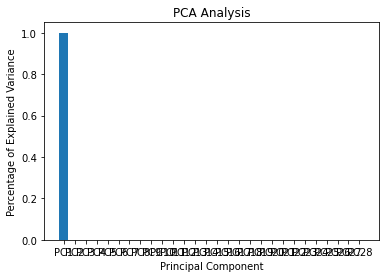

In [40]:
per_var = np.round(pca.explained_variance_ratio_, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('PCA Analysis')
plt.show()

In [41]:
for i in range(1,18):
    print("Variance held by "+ str(i) + " PCs: {}".format(sum(pca.explained_variance_ratio_[:i])))

Variance held by 1 PCs: 0.9999999999999479
Variance held by 2 PCs: 0.9999999999999881
Variance held by 3 PCs: 0.9999999999999937
Variance held by 4 PCs: 0.9999999999999981
Variance held by 5 PCs: 0.9999999999999996
Variance held by 6 PCs: 1.0
Variance held by 7 PCs: 1.0
Variance held by 8 PCs: 1.0
Variance held by 9 PCs: 1.0
Variance held by 10 PCs: 1.0
Variance held by 11 PCs: 1.0
Variance held by 12 PCs: 1.0
Variance held by 13 PCs: 1.0
Variance held by 14 PCs: 1.0
Variance held by 15 PCs: 1.0
Variance held by 16 PCs: 1.0
Variance held by 17 PCs: 1.0


In [42]:
pca = PCA(n_components = 10)
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)

x_pca['receita_predicted']=y
x_pca.columns = ['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6', '7', '8', '9', '10', 'receita_predicted']
x_pca.tail()

,PC1,PC2,PC3,PC4,PC5,PC6,7,8,9,10,receita_predicted
73624,-1.017172e+12,-108079.769380,154.072202,-43728.320879,-26024.013591,1323.649720,-42.811477,-1993.341670,1.015374,-1.745251,71171.48
73625,-1.017172e+12,-115040.394288,-13161.859073,-41978.037925,-27797.401722,1544.825178,-32.458401,-1989.603704,1.068293,-1.638279,48284.66
73626,-1.017172e+12,-131423.629656,-3148.335899,-38699.979081,-30827.451966,-3338.802024,-24.513556,-1979.476012,1.287303,-1.418733,61198.10
73627,-1.017172e+12,-122646.861279,13319.123845,-39693.029222,-28196.270905,-3745.452120,-39.328454,-1984.428417,1.168522,-1.800330,73877.02
73628,-1.017172e+12,-72918.866814,115887.141553,-80161.168865,-24628.115888,-2382.335704,-72.752242,-2005.649696,0.884281,-2.405867,186545.24


In [43]:
##cross-validation
Y = x_pca['receita_predicted']
X = x_pca.loc[:, x_pca.columns != 'receita_predicted']
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=0, test_size=0.3)

In [44]:
#DEGREE 1:
get_polynomial_features_model(train_X, val_X, train_y, val_y, 1)

The model performance:

RMSE of test set is 38522.10376293105
R2 score of test set is 0.8838650270520526
adjusted-R2 score of test set is 0.8838424892630508


In [45]:
#DEGREE 2:
get_polynomial_features_model(train_X, val_X, train_y, val_y, 2)

The model performance:

RMSE of test set is 33748.837744340046
R2 score of test set is 0.9108624543831609
adjusted-R2 score of test set is 0.9108451558627905


In [46]:
#DEGREE 3:
get_polynomial_features_model(train_X, val_X, train_y, val_y, 3)

The model performance:

RMSE of test set is 31092.96005079519
R2 score of test set is 0.9243398553277248
adjusted-R2 score of test set is 0.9243251723056067


In [47]:
#DEGREE 4:
get_polynomial_features_model(train_X, val_X, train_y, val_y, 4)

The model performance:

RMSE of test set is 35818.222909428296
R2 score of test set is 0.8995959804812408
adjusted-R2 score of test set is 0.8995764955272306


In [48]:
#DEGREE 5:
get_polynomial_features_model(train_X, val_X, train_y, val_y, 5)

The model performance:

RMSE of test set is 161081.8998798447
R2 score of test set is -1.0306567363688628
adjusted-R2 score of test set is -1.0310508167384351


In [ ]:
#DEGREE 6:
get_polynomial_features_model(train_X, val_X, train_y, val_y, 6)

In [ ]:
get_rmse_matrix(df_master_data)